In [2]:
import pandas as pd
import numpy as np

historydf= pd.read_csv('C:/Users/veryv/OneDrive/桌面/Stock_data/full_history/MSFT(after2008).csv', index_col=0 )
historydf.dropna(how='any',inplace=True)

In [3]:
#正規化資料
from sklearn import preprocessing

def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['adjclose'] = min_max_scaler.fit_transform(df.adjclose.values.reshape(-1,1))
    
    return newdf

historydf_norm= normalize(historydf)

In [4]:
historydf_norm=historydf_norm.astype('float32')

In [5]:
historydf_norm.head()

,volume,open,close,high,low,adjclose
date,,,,,,
2009/1/2,0.136773,0.040471,0.047865,0.044300,0.042281,0.035374
2009/1/5,0.173296,0.046733,0.049621,0.046803,0.048764,0.036698
2009/1/6,0.162421,0.051874,0.051839,0.049861,0.053932,0.038370
2009/1/7,0.209317,0.046640,0.040288,0.043281,0.043315,0.029659
2009/1/8,0.201447,0.041406,0.045925,0.042354,0.043973,0.033910


In [6]:
#切分資料
def data_split(data,sample):
    # 資料維度: 開盤價、收盤價、最高價、最低價、成交量... 6維
    feature = len(data.columns)
    
    # 將dataframe 轉成 numpy array
    data = data.as_matrix()
    newdata = []
    y_data = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for i in range(len(data)-sample):# 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        newdata.append(data[i:(i+sample)])# 逐筆取出 time_frame+1 個 K棒數值做為一筆 instance
        y_data.append(data[i+sample,-1:])
        
    n_train = round(0.8*len(newdata))# 取 result 的前 80% instance做為訓練資料
    newdata = np.array(newdata)
    
    x_train = newdata[:int(n_train)] 
    y_train = y_data[:int(n_train)] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    x_test = newdata[int(n_train):]
    y_test = y_data[int(n_train):]

    # 將資料組成變好看一點
    x_train = x_train.reshape(-1, 30, 6)
    x_test = x_test.reshape(-1, 30, 6)
    return x_train,np.array(y_train), x_test, np.array(y_test)

# 以20天為一區間進行股價預測
x_train,y_train,x_test,y_test= data_split(historydf_norm,20)

C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [7]:
x_train.shape

(2049, 30, 6)

In [8]:
len(y_train)

2049

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch as t
from torch import nn
from torch.autograd import Variable

In [10]:
x_train = t.from_numpy(x_train)
y_train = t.from_numpy(y_train)
x_test = t.from_numpy(x_test)
y_test = t.from_numpy(y_test)

In [11]:
from torch import nn
from torch.autograd import Variable

#定義模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2, dropout = 0.5):
            super(lstm_reg, self).__init__()
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout = dropout)
            self.reg = nn.Linear(30*hidden_size, output_size)
          
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state
        r_out = r_out.reshape(r_out.shape[0], r_out.shape[1]*r_out.shape[2])
        r_out = t.sin(r_out)
        out = self.reg(r_out)
        return out
net = lstm_reg(6, 64)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-2)

In [12]:
for name, param in net.named_parameters():
    print(name, param.size())

rnn.weight_ih_l0 torch.Size([256, 6])
rnn.weight_hh_l0 torch.Size([256, 64])
rnn.bias_ih_l0 torch.Size([256])
rnn.bias_hh_l0 torch.Size([256])
rnn.weight_ih_l1 torch.Size([256, 64])
rnn.weight_hh_l1 torch.Size([256, 64])
rnn.bias_ih_l1 torch.Size([256])
rnn.bias_hh_l1 torch.Size([256])
reg.weight torch.Size([1, 1920])
reg.bias torch.Size([1])


In [14]:
#迭代50次
for e in range(50):
    var_x = Variable(x_train)
    var_y = Variable(y_train)
 
    out = net(var_x)
    print(out.shape)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.data[0]))
        
t.save(net.state_dict(), 'net_params.pkl')

torch.Size([2049, 1])


C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Epoch: 1, Loss:0.88153
torch.Size([2049, 1])
Epoch: 2, Loss:0.18712
torch.Size([2049, 1])
Epoch: 3, Loss:0.13985
torch.Size([2049, 1])
Epoch: 4, Loss:0.01643
torch.Size([2049, 1])
Epoch: 5, Loss:0.04150
torch.Size([2049, 1])
Epoch: 6, Loss:0.04822
torch.Size([2049, 1])
Epoch: 7, Loss:0.01268
torch.Size([2049, 1])
Epoch: 8, Loss:0.03299
torch.Size([2049, 1])
Epoch: 9, Loss:0.05123
torch.Size([2049, 1])
Epoch: 10, Loss:0.03024
torch.Size([2049, 1])
Epoch: 11, Loss:0.01147
torch.Size([2049, 1])
Epoch: 12, Loss:0.02206
torch.Size([2049, 1])
Epoch: 13, Loss:0.03189
torch.Size([2049, 1])
Epoch: 14, Loss:0.01843
torch.Size([2049, 1])
Epoch: 15, Loss:0.00663
torch.Size([2049, 1])
Epoch: 16, Loss:0.01106
torch.Size([2049, 1])
Epoch: 17, Loss:0.01796
torch.Size([2049, 1])
Epoch: 18, Loss:0.01343
torch.Size([2049, 1])
Epoch: 19, Loss:0.00346
torch.Size([2049, 1])
Epoch: 20, Loss:0.00257
torch.Size([2049, 1])
Epoch: 21, Loss:0.00967
torch.Size([2049, 1])
Epoch: 22, Loss:0.00840
torch.Size([2049, 1

### Training result

In [15]:
var_data = Variable(x_train)
pred_train = net(var_data) # 訓練集的预测结果
pred_train = pred_train.view(-1).data.numpy()
y_train = y_train.view(-1).data.numpy()

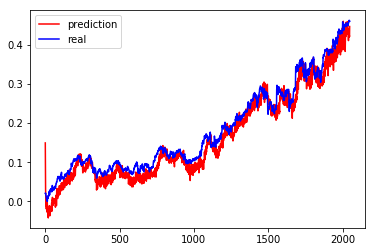

In [16]:
plt.plot(pred_train, 'r', label='prediction')
plt.plot(y_train, 'b', label='real')
plt.legend(loc='best')
plt.show()

### Testing result

In [17]:
var_data = Variable(x_test)
pred_test = net(var_data) # 测试集的预测结果
pred_test = pred_test.view(-1).data.numpy()
y_test = y_test.view(-1).data.numpy()

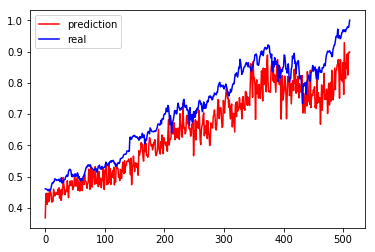

In [18]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.legend(loc='best')
plt.show()